In [1]:
import pandas as pd

In [2]:
df_letters = pd.read_csv('all_lettters_with_entities_final.tsv',sep='\t')

In [3]:
docs_we_looked_at = set(df_letters['filename'].astype(int).tolist()) 
# before extracting entities: we knew these docs exist, whether they have entities is another question



In [4]:
df_graph = pd.read_csv('df_graph_with_wikidata.tsv',sep='\t')
df_graph_manual = pd.read_csv('/ivi/ilps/personal/vprovat/valkema_graph_directed_manual.tsv',sep='\t')

In [5]:
docs_manual = set()
for item in df_graph_manual['document_ids']:
    doc_ids = [int(di) for di in eval(item)]
    docs_manual = docs_manual.union(set(doc_ids))

In [6]:
import json
# alias = json.load(open('alias_dictionary_corrected.jsonl','r'))
aka = json.load(open('also_known_as_final.json','r'))

alias = {}
for main_name, names in aka.items():
    for name in names:
        alias[name] = main_name
        
def resolve_alias(p):
    cnt = 0
    while p in alias and cnt < 10:
        p = alias[p]
        cnt += 1
    if cnt == 10:
        print('Got a loop in aliases! Starting point: ',p)
    return p

df_graph_manual['person1'] = df_graph_manual['person1'].apply(resolve_alias)
df_graph_manual['person2'] = df_graph_manual['person2'].apply(resolve_alias)

In [7]:
def has_been_seen(doc_ids):
    return len(set([int(doc_id) for doc_id in eval(doc_ids)]).intersection(docs_we_looked_at)) > 0

In [8]:
df_graph_manual['has_been_seen'] = df_graph_manual['document_ids'].map(has_been_seen)

In [9]:
df_graph_manual = df_graph_manual[df_graph_manual['has_been_seen']]

In [10]:
df = df_graph.merge(df_graph_manual, on=['person1', 'person2'], how='outer', indicator=True).drop(['main_country1',
                                                                                                  'main_country2',
                                                                                                   'weight',
                                                                                                  'countries1',
                                                                                                  'countries2'],
                                                                                                 axis=1)

In [11]:
df_found = df[df['_merge']=='both']
len(df_found)

18

In [12]:
df_missing_connections = df[df['_merge']=='right_only']
df_missing_connections

,person1,person2,document_ids_x,wikidata_id1,wikidata_description1,wikidata_id2,wikidata_description2,document_ids_y,has_been_seen,_merge
37559,Bernardine de Neeve,Sybren and Veronique Valkema,NaN,NaN,NaN,NaN,NaN,"['1310885', '1310886', '1310889', '1310890', '...",True,right_only
37560,Binte Saetrang,Sybren Valkema,NaN,NaN,NaN,NaN,NaN,['1318445'],True,right_only
37561,C. Bachmann,Sybren Valkema,NaN,NaN,NaN,NaN,NaN,['1284039'],True,right_only
37562,Jan Antonie de Melker,Sybren Valkema,NaN,NaN,NaN,NaN,NaN,"['1262435', '1262439']",True,right_only
37563,Boris,Sybren Valkema,NaN,NaN,NaN,NaN,NaN,['1262437'],True,right_only
...,...,...,...,...,...,...,...,...,...,...
37759,Erich Aschenbrenner,Sybren Valkema,NaN,NaN,NaN,NaN,NaN,"['1310332', '1310334']",True,right_only
37760,Erika Waltrand,Sybren Valkema,NaN,NaN,NaN,NaN,NaN,"['1310348', '1310350']",True,right_only
37761,Dani and Laor,Sybren and Veronique Valkema,NaN,NaN,NaN,NaN,NaN,"['1310362', '1310364', '1310366', '1310367', '...",True,right_only
37762,Galina,Sybren and Veronique Valkema,NaN,NaN,NaN,NaN,NaN,"['1310378', '1310379', '1310380', '1310381']",True,right_only


In [13]:
df_ok_or_missing = pd.concat([df_missing_connections,df_found])

In [14]:
def what_has_been_seen(doc_ids):
    return set([int(doc_id) for doc_id in eval(doc_ids)]).intersection(docs_we_looked_at)

In [15]:
df_ok_or_missing['doc_ids'] = df_ok_or_missing['document_ids_y'].map(what_has_been_seen)
df_ok_or_missing = df_ok_or_missing[['person1','person2', 'doc_ids','_merge']]
# Convert sets to lists
df_ok_or_missing['doc_ids'] = df_ok_or_missing['doc_ids'].apply(list)
df_ok_or_missing

,person1,person2,doc_ids,_merge
37559,Bernardine de Neeve,Sybren and Veronique Valkema,"[1310885, 1310886, 1310889, 1310890, 1310891]",right_only
37560,Binte Saetrang,Sybren Valkema,[1318445],right_only
37561,C. Bachmann,Sybren Valkema,[1284039],right_only
37562,Jan Antonie de Melker,Sybren Valkema,"[1262435, 1262439]",right_only
37563,Boris,Sybren Valkema,[1262437],right_only
...,...,...,...,...
4057,Gibson Byrd,Sybren Valkema,"[1268546, 1268564, 1268554]",both
4060,H. Spoor,Sybren Valkema,"[1269218, 1269214]",both
13337,Maureen Michelson,Sybren Valkema,"[1311171, 1311141, 1311175, 1311129, 1311131]",both
29635,Albert Lewis,Sybren Valkema,"[1311197, 1311235, 1311205, 1311211, 1311215, ...",both


In [16]:
df_ok_or_missing.to_csv('manual_connections_for_evaluation.tsv',sep='\t',index=False)

In [42]:
df_ok_or_missing_flat = df_ok_or_missing.explode('doc_ids').reset_index(drop=True)
df_ok_or_missing_flat['doc_id'] = df_ok_or_missing_flat['doc_ids']
df_ok_or_missing_flat.drop('doc_ids',axis=1)
df_ok_or_missing_flat

,person1,person2,doc_ids,_merge,doc_id
0,Bernardine de Neeve,Sybren and Veronique Valkema,1310885,right_only,1310885
1,Bernardine de Neeve,Sybren and Veronique Valkema,1310886,right_only,1310886
2,Bernardine de Neeve,Sybren and Veronique Valkema,1310889,right_only,1310889
3,Bernardine de Neeve,Sybren and Veronique Valkema,1310890,right_only,1310890
4,Bernardine de Neeve,Sybren and Veronique Valkema,1310891,right_only,1310891
...,...,...,...,...,...
589,Albert Lewis,Sybren Valkema,1311199,both,1311199
590,Rob Nieuwenhuys,Sybren Valkema,1310240,both,1310240
591,Rob Nieuwenhuys,Sybren Valkema,1310234,both,1310234
592,Rob Nieuwenhuys,Sybren Valkema,1310235,both,1310235


In [43]:
df_sample = df_ok_or_missing_flat.sample(n=120)

In [44]:
df_sample.to_csv('sample_for_error_analysis.tsv',sep='\t')

In [13]:
def filter_doc_ids(doc_ids_raw): # document ids have an overlap with documents processed manually
    res = []
    doc_ids = eval(doc_ids_raw)
    for item in doc_ids:
        docs_seen = set()
        for di_raw in item.split('-'):
            docs_seen.add(int(di_raw))
        if len(docs_seen.intersection(docs_manual)) > 0:
            res.append(item)
            
    return res

In [14]:
from tqdm.auto import tqdm
tqdm.pandas()
df_extra_connections['filtered_doc_ids'] = df_extra_connections['document_ids_x'].progress_apply(filter_doc_ids)

NameError: name 'df_extra_connections' is not defined

In [22]:
df_extra_connections['is_ok'] = df_extra_connections['filtered_doc_ids'].apply(lambda x: len(x)>0)
df_extra_connections = df_extra_connections[df_extra_connections['is_ok']]
df_extra_connections

/home/vprovat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,person1,person2,document_ids_x,wikidata_id1,wikidata_description1,wikidata_id2,wikidata_description2,document_ids_y,_merge,filtered_doc_ids,is_ok
1,Bert Haanstra,Sybren Valkema,['0001246763-0001246764-0001246765-0001246766-...,Q827371,Dutch film director (1916-1997),Q2618110,Dutch glass artist (1916-1996),NaN,left_only,[0001256051-0001256052-0001256053-0001256054-0...,True
2,Jane Bruce,Sybren Valkema,['0001246763-0001246764-0001246765-0001246766-...,Q16031419,Canadian teacher,Q2618110,Dutch glass artist (1916-1996),NaN,left_only,[0001288226-0001288227-0001288228-0001288229-0...,True
3,Frits Gramberg,Sybren Valkema,['0001246763-0001246764-0001246765-0001246766-...,Q42429178,Description not found.,Q2618110,Dutch glass artist (1916-1996),NaN,left_only,[0001258393-0001258394-0001258395-0001258396-0...,True
12,Durk Valkema,van der Linden,"['0001246783-0001246784', '0001246881-00012468...",Q29422094,Dutch sculptor,Q108533978,Dutch photographer,NaN,left_only,[0001256051-0001256052-0001256053-0001256054-0...,True
13,Gerrit Rietveld,Walter Lieberman,['0001246787-0001246788-0001246789-0001246790-...,Q160435,Dutch furniture designer and architect (1888-1...,Q113467601,glass atist,NaN,left_only,[0001288226-0001288227-0001288228-0001288229-0...,True
...,...,...,...,...,...,...,...,...,...,...,...
37511,Durk Valkema,John Schlesinger,['0001459873-0001459874-0001459875-0001459876-...,Q29422094,Dutch sculptor,Q55303,English film and stage director (1926–2003),NaN,left_only,[0001459873-0001459874-0001459875-0001459876-0...,True
37512,David Niven,Durk Valkema,['0001459873-0001459874-0001459875-0001459876-...,Q181917,British actor and novelist (1910–1983),Q29422094,Dutch sculptor,NaN,left_only,[0001459873-0001459874-0001459875-0001459876-0...,True
37513,Durk Valkema,Terence Stamp,['0001459873-0001459874-0001459875-0001459876-...,Q29422094,Dutch sculptor,Q77298,British actor,NaN,left_only,[0001459873-0001459874-0001459875-0001459876-0...,True
37514,Durk Valkema,Eli Wallach,['0001459873-0001459874-0001459875-0001459876-...,Q29422094,Dutch sculptor,Q104067,American actor (1915–2014),NaN,left_only,[0001459873-0001459874-0001459875-0001459876-0...,True


In [24]:
df_extra_connections_sample = df_extra_connections.sample(n=25).drop(['document_ids_y',
                                                                     '_merge','document_ids_x',
                                                                     'is_ok'],axis=1)
df_extra_connections_sample

,person1,person2,wikidata_id1,wikidata_description1,wikidata_id2,wikidata_description2,filtered_doc_ids
13542,G. Scholten,Lino Tagliapietra,Q47125828,botanist,Q6554691,Italian glass artist,[0001308132-0001308133-0001308134-0001308135-0...
4777,Fritz Dreisbach,Joey Kirkpatrick,Q5504896,"Glass artist, educator",Q106629623,glass artist,[0001288226-0001288227-0001288228-0001288229-0...
33609,Leendert van der Linden,Vincent van Ginneke,Q124567571,master glass blower,Q22236382,Dutch sculptor,[0001307938-0001307939-0001307940-0001307941-0...
14377,Joanna Brom,Matthew Black,Q19587710,Description not found.,Q3299669,Scottish minister and biblical scholar (1908–1...,[0001283464-0001283465-0001283466-0001283467-0...
36399,Sarah Miles,Sergio Leone,Q231187,British actress,Q164562,Italian filmmaker (1929-1989),[0001459874-0001459875-0001459876-0001459877-0...
31651,Lambertus Zijl,Sybren Valkema,Q2669966,Dutch sculptor and medalist (1866-1947),Q2618110,Dutch glass artist (1916-1996),[0001307938-0001307939-0001307940-0001307941-0...
30638,Marvin Lipofsky,S. van Dijk,Q6778409,"Artist, educator",Q125390140,Description not found.,[0001307938-0001307939-0001307940-0001307941-0...
20646,Erwin Eisch,Tony Jojola,Q1362910,"Glass artist, educator",Q111264582,"artist, born 1958",[0001288226-0001288227-0001288228-0001288229-0...
20026,Josephine Schaper,Robbie Miller,Q110320774,Description not found.,Q21556383,glass artist,[0001288226-0001288227-0001288228-0001288229-0...
2242,Dirk Vis,Irene Vonck,Q2202296,"Dutch painter, illustrator and draughtsperson ...",Q29422233,Description not found.,[0001256051-0001256052-0001256053-0001256054-0...


In [25]:
df_extra_connections_sample.to_csv('extra_connections_for_manual_evaluation.tsv',sep='\t')

In [ ]:
# OLD CODE BEGINS HERE

In [20]:
# let's consider the Valkema family as one unit
def valkemify(item):
    return 'Valkema' if item.find('Valkema') != -1 else item

# df_family = merged_Valkema.copy()
df_family_auto = df_graph.copy()
df_family_auto['person1'] = df_family_auto['person1'].apply(valkemify)
df_family_auto['person2'] = df_family_auto['person2'].apply(valkemify)
df_family_auto = df_family_auto.drop_duplicates(subset=['person1','person2'])

df_family_manual = df_graph_manual.copy()
df_family_manual['person1'] = df_family_manual['person1'].apply(valkemify)
df_family_manual['person2'] = df_family_manual['person2'].apply(valkemify)
df_family_manual = df_family_manual.drop_duplicates(subset=['person1','person2'])

df_family = df_family_auto.merge(df_family_manual, on=['person1', 'person2'], how='outer', indicator=True)
df_family

,person1,person2,document_ids_x,document_ids_y,_merge
0,P. A. Stoon,v.d.Berg,['0001246763-0001246764-0001246765-0001246766-...,NaN,left_only
1,Wim Crouwel,v.d.Berg,['0001246763-0001246764-0001246765-0001246766-...,NaN,left_only
2,Rietveld,v.d.Berg,['0001246763-0001246764-0001246765-0001246766-...,NaN,left_only
3,Stolle,v.d.Berg,['0001246763-0001246764-0001246765-0001246766-...,NaN,left_only
4,Kho Liang Ie,v.d.Berg,['0001246763-0001246764-0001246765-0001246766-...,NaN,left_only
...,...,...,...,...,...
256340,J. J. Walraven,Valkema,NaN,['1310314'],right_only
256341,Erika Waltrand,Valkema,NaN,"['1310348', '1310350']",right_only
256342,Dani and Laor,Valkema,NaN,"['1310362', '1310364', '1310366', '1310367', '...",right_only
256343,Galina,Valkema,NaN,"['1310378', '1310379', '1310380', '1310381']",right_only


In [21]:
df_family_extra_connections = df_family[df_family['_merge']=='left_only']
df_family_extra_connections

,person1,person2,document_ids_x,document_ids_y,_merge
0,P. A. Stoon,v.d.Berg,['0001246763-0001246764-0001246765-0001246766-...,NaN,left_only
1,Wim Crouwel,v.d.Berg,['0001246763-0001246764-0001246765-0001246766-...,NaN,left_only
2,Rietveld,v.d.Berg,['0001246763-0001246764-0001246765-0001246766-...,NaN,left_only
3,Stolle,v.d.Berg,['0001246763-0001246764-0001246765-0001246766-...,NaN,left_only
4,Kho Liang Ie,v.d.Berg,['0001246763-0001246764-0001246765-0001246766-...,NaN,left_only
...,...,...,...,...,...
256177,Joë,P.Keune,['0001457649-0001457650-0001457651-0001457652-...,NaN,left_only
256178,P.Keune,Sam Herman,['0001457649-0001457650-0001457651-0001457652-...,NaN,left_only
256179,John Cook,Joë,['0001457649-0001457650-0001457651-0001457652-...,NaN,left_only
256180,Joë,Sam Herman,['0001457649-0001457650-0001457651-0001457652-...,NaN,left_only


In [26]:
def is_ok_for_extra(doc_ids_raw): # document ids have an overlap with documents processed manually
    docs_seen = set()
    doc_ids = eval(doc_ids_raw)
    for item in doc_ids:
        for di_raw in item.split('-'):
            docs_seen.add(int(di_raw))
            
    return len(docs_seen.intersection(docs_manual))>0

In [39]:
def filter_doc_ids(doc_ids_raw): # document ids have an overlap with documents processed manually
    res = []
    doc_ids = eval(doc_ids_raw)
    for item in doc_ids:
        docs_seen = set()
        for di_raw in item.split('-'):
            docs_seen.add(int(di_raw))
        if len(docs_seen.intersection(docs_manual)) > 0:
            res.append(item)
            
    return res

In [40]:
from tqdm.auto import tqdm
tqdm.pandas()
# df_family_extra_connections['is_ok'] = df_family_extra_connections['document_ids_x'].progress_apply(is_ok_for_extra)
df_family_extra_connections['filtered_doc_ids'] = df_family_extra_connections['document_ids_x'].progress_apply(filter_doc_ids)

  0%|          | 0/181432 [00:00<?, ?it/s]

/home/vprovat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [42]:
df_family_extra_connections['is_ok'] = df_family_extra_connections['filtered_doc_ids'].apply(lambda x: len(x)>0)
df_family_extra_connections = df_family_extra_connections[df_family_extra_connections['is_ok']]
df_family_extra_connections

/home/vprovat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,person1,person2,document_ids_x,document_ids_y,_merge,is_ok,filtered_doc_ids
76,Rietveld,Valkema,['0001246763-0001246764-0001246765-0001246766-...,NaN,left_only,True,[0001268576-0001268577-0001268578-0001268579-0...
161,Arts,Valkema,['0001246763-0001246764-0001246765-0001246766-...,NaN,left_only,True,[0001288226-0001288227-0001288228-0001288229-0...
185,Bert Haanstra,Corina Teunisse van Manen,['0001246763-0001246764-0001246765-0001246766-...,NaN,left_only,True,[0001256051-0001256052-0001256053-0001256054-0...
188,Bert Haanstra,Valkema,['0001246763-0001246764-0001246765-0001246766-...,NaN,left_only,True,[0001256047-0001256048-0001256049-0001256050-0...
200,Corina Teunisse van Manen,Valkema,['0001246763-0001246764-0001246765-0001246766-...,NaN,left_only,True,[0001307938-0001307939-0001307940-0001307941-0...
...,...,...,...,...,...,...,...
255192,Dousman,Walkerville,['0001459908-0001459909-0001459910-0001459911-...,NaN,left_only,True,[0001459908-0001459909-0001459910-0001459911-0...
255193,Vern,Walkerville,['0001459908-0001459909-0001459910-0001459911-...,NaN,left_only,True,[0001459908-0001459909-0001459910-0001459911-0...
255194,Don Reitz,Wm Spring Green,['0001459918-0001459919-0001459920-0001459921-...,NaN,left_only,True,[0001459918-0001459919-0001459920-0001459921-0...
255195,Takalso Saml,Wilke Adolfsson,['0001468399-0001468400-0001468401-0001468402'],NaN,left_only,True,[0001468399-0001468400-0001468401-0001468402]


In [43]:
df_family_extra_connections_sample = df_family_extra_connections.sample(n=25)
df_family_extra_connections_sample

,person1,person2,document_ids_x,document_ids_y,_merge,is_ok,filtered_doc_ids
81423,Dini Becker,Kneulman,['0001283464-0001283465-0001283466-0001283467-...,NaN,left_only,True,[0001283464-0001283465-0001283466-0001283467-0...
127325,Michael Bray,Nick Cave,['0001288228-0001288229-0001288230-0001288231-...,NaN,left_only,True,[0001288226-0001288227-0001288228-0001288229-0...
213848,Susan Hammond,Tagliapietra,['0001307938-0001307939-0001307940-0001307941-...,NaN,left_only,True,[0001307938-0001307939-0001307940-0001307941-0...
209661,Henk-Adriuun,Peter Tysoe,['0001307938-0001307939-0001307940-0001307941-...,NaN,left_only,True,[0001307938-0001307939-0001307940-0001307941-0...
138620,Ann Lawrence,Louis Pepper,['0001288228-0001288229-0001288230-0001288231-...,NaN,left_only,True,[0001288226-0001288227-0001288228-0001288229-0...
156688,Maurine Littleton,Picasso,['0001288228-0001288229-0001288230-0001288231-...,NaN,left_only,True,[0001288226-0001288227-0001288228-0001288229-0...
79007,Joke Pennekamp,Jos Lerinckx,['0001283464-0001283465-0001283466-0001283467-...,NaN,left_only,True,[0001283464-0001283465-0001283466-0001283467-0...
182573,Don G. Abel,Gary Nash,['0001288228-0001288229-0001288230-0001288231-...,NaN,left_only,True,[0001288226-0001288227-0001288228-0001288229-0...
150535,Gene Koss,Lailla Petersen,['0001288228-0001288229-0001288230-0001288231-...,NaN,left_only,True,[0001288226-0001288227-0001288228-0001288229-0...
243046,Joseph Rees,Michael Taylor,['0001311133-0001311134-0001311135-0001311136-...,NaN,left_only,True,[0001311133-0001311134-0001311135-0001311136-0...


In [45]:
df_family_extra_connections_sample = df_family_extra_connections_sample[['person1',
                                                                         'person2',
                                                                         'filtered_doc_ids']]
df_family_extra_connections_sample

,person1,person2,filtered_doc_ids
81423,Dini Becker,Kneulman,[0001283464-0001283465-0001283466-0001283467-0...
127325,Michael Bray,Nick Cave,[0001288226-0001288227-0001288228-0001288229-0...
213848,Susan Hammond,Tagliapietra,[0001307938-0001307939-0001307940-0001307941-0...
209661,Henk-Adriuun,Peter Tysoe,[0001307938-0001307939-0001307940-0001307941-0...
138620,Ann Lawrence,Louis Pepper,[0001288226-0001288227-0001288228-0001288229-0...
156688,Maurine Littleton,Picasso,[0001288226-0001288227-0001288228-0001288229-0...
79007,Joke Pennekamp,Jos Lerinckx,[0001283464-0001283465-0001283466-0001283467-0...
182573,Don G. Abel,Gary Nash,[0001288226-0001288227-0001288228-0001288229-0...
150535,Gene Koss,Lailla Petersen,[0001288226-0001288227-0001288228-0001288229-0...
243046,Joseph Rees,Michael Taylor,[0001311133-0001311134-0001311135-0001311136-0...


In [47]:
df_family_extra_connections_sample.to_csv('extra_connections_for_manual_evaluation.tsv',sep='\t')

In [34]:
from PIL import Image
def show_image(filename):
    df_target = df_letters[df_letters['filename'] == filename]
    img_path_big = df_target.iloc[0]['path_to_image']
    img_path = img_path_big.replace('TIF','JPG').replace('tif','jpg')
    print(img_path)
    try:
        img = Image.open(img_path)
    except:
        img = Image.open(img_path_big)
    display(img)
#     print(img_path_big)

In [35]:
def show_text(filename):
    df_target = df_entities[df_entities['filename'] == filename]
    text_path = df_target.iloc[0]['path_to_text']
    print(text_path)
    try:
        with open(text_path,'r') as f:
            print(f.read())
    except:
        print('failed to find text at: ',text_path)

/ivi/ilps/projects/ArtDATIS/valkema/MMRKD07_000000014_1_01/Afgeleiden/JPG/372/0001283467.jpg


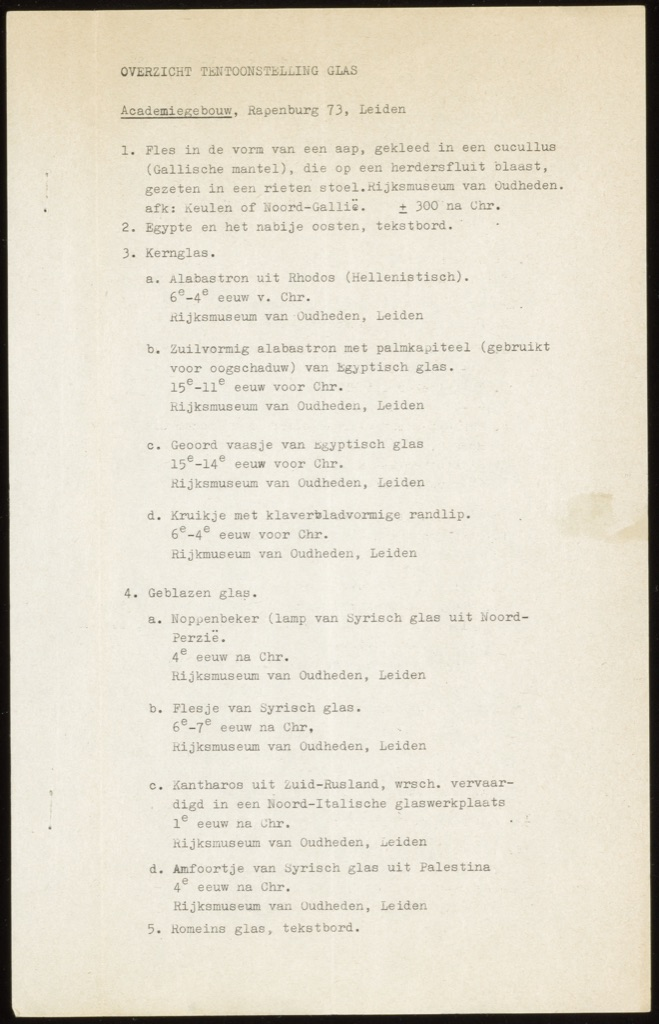

In [48]:
show_image(1283467)

In [8]:
alias['Takako Sand']

'Pakako Sano'

In [9]:
'Kitty Fischer' in aka

False

In [10]:
alias['K.Fischer']

'K Fischer'